# Neural Style Transfer 
In this we will copy the style of one image (style_image) and use that style on another image(content_image).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# Visualizing Images
Visualizing the content and style images 

In [3]:
import matplotlib.image as mpimg

def plot_image(path):
    
    plt.figure(figsize=(6, 6), dpi=200)
    plt.imshow(mpimg.imread(path))
    plt.axis('off')

    print(f'Image shape: {mpimg.imread(path).shape} \n')

Image shape: (3448, 4592, 3) 



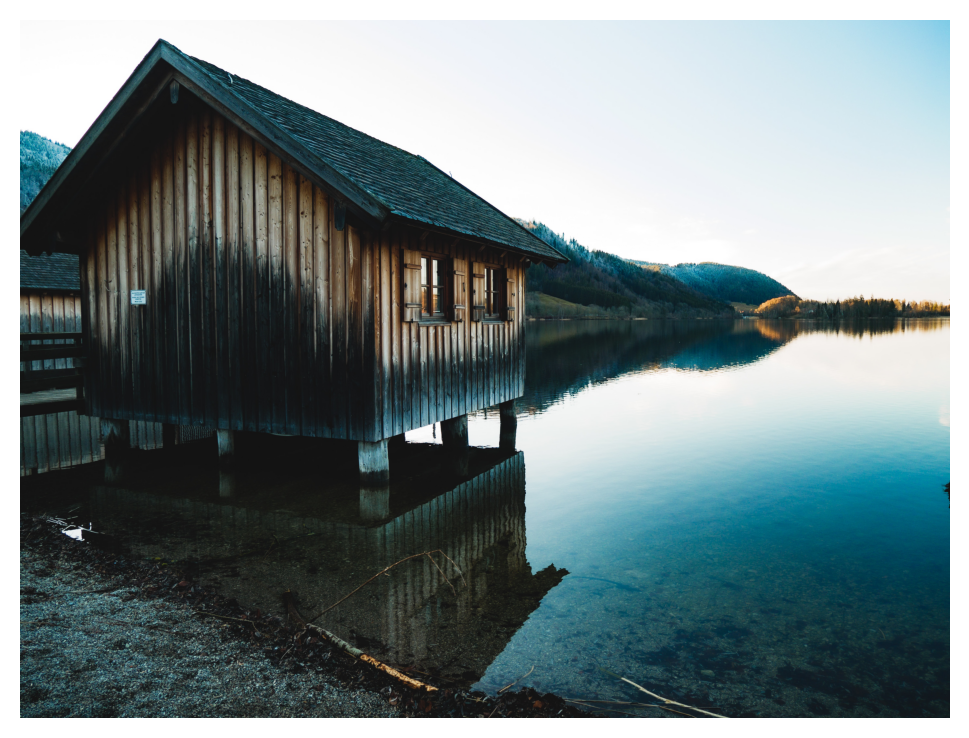

In [4]:
plot_image('/content/drive/MyDrive/Neural Style Transfer/Images/john-paul-dorf-uBoNVPmh-V8-unsplash.jpg')

Image shape: (599, 756, 3) 



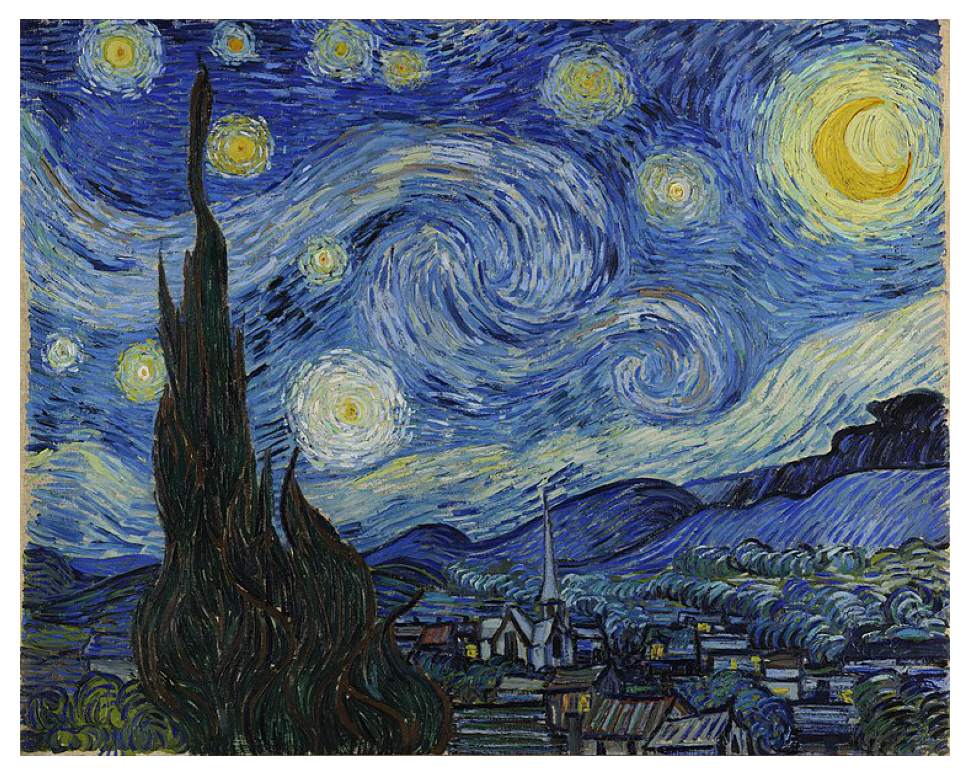

In [5]:
plot_image('/content/drive/MyDrive/Neural Style Transfer/Images/Van_Gogh - Starry_Night_.jpg')

# Getting VGG19 Model 

In [6]:
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=True)

for layers in vgg.layers:
    print(f'{layers.name} ----> {layers.output_shape}')

574726144/574710816 [==============================] - 3s 0us/step
input_1 ----> [(None, 224, 224, 3)]
block1_conv1 ----> (None, 224, 224, 64)
block1_conv2 ----> (None, 224, 224, 64)
block1_pool ----> (None, 112, 112, 64)
block2_conv1 ----> (None, 112, 112, 128)
block2_conv2 ----> (None, 112, 112, 128)
block2_pool ----> (None, 56, 56, 128)
block3_conv1 ----> (None, 56, 56, 256)
block3_conv2 ----> (None, 56, 56, 256)
block3_conv3 ----> (None, 56, 56, 256)
block3_conv4 ----> (None, 56, 56, 256)
block3_pool ----> (None, 28, 28, 256)
block4_conv1 ----> (None, 28, 28, 512)
block4_conv2 ----> (None, 28, 28, 512)
block4_conv3 ----> (None, 28, 28, 512)
block4_conv4 ----> (None, 28, 28, 512)
block4_pool ----> (None, 14, 14, 512)
block5_conv1 ----> (None, 14, 14, 512)
block5_conv2 ----> (None, 14, 14, 512)
block5_conv3 ----> (None, 14, 14, 512)
block5_conv4 ----> (None, 14, 14, 512)
block5_pool ----> (None, 7, 7, 512)
flatten ----> (None, 25088)
fc1 ----> (None, 4096)
fc2 ----> (None, 4096)
pred

In [7]:
content_path = '/content/drive/MyDrive/Neural Style Transfer/Images/john-paul-dorf-uBoNVPmh-V8-unsplash.jpg'
style_path = '/content/drive/MyDrive/Neural Style Transfer/Images/Van_Gogh - Starry_Night_.jpg'
IMG_SIZE = (224, 224)
model_weights_path = '/content/drive/MyDrive/Neural Style Transfer/vgg19_weights_tf_dim_ordering_tf_kernels.h5'

In [8]:
%matplotlib inline

content_image = cv2.resize(cv2.imread(content_path), IMG_SIZE)
content_image = tf.image.convert_image_dtype(content_image, tf.float32)

style_image = cv2.resize(cv2.imread(style_path), (224, 224))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)

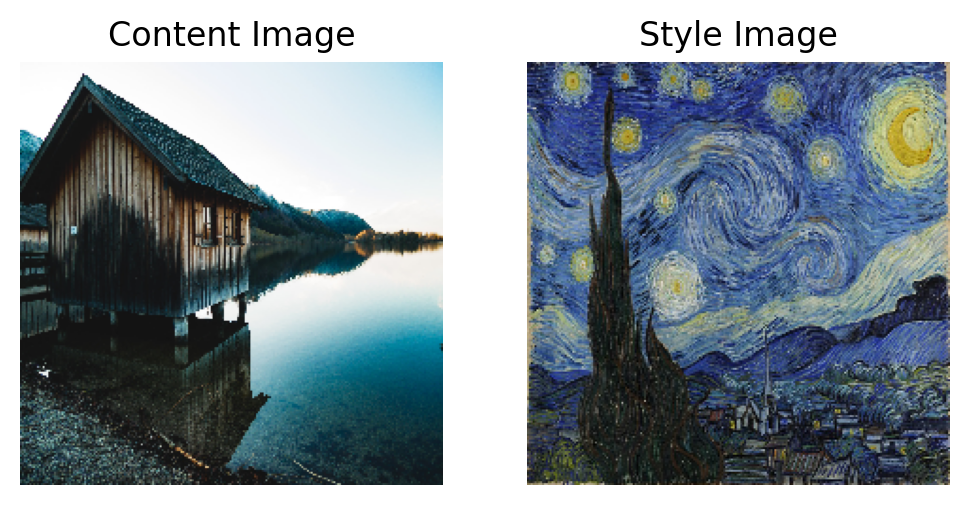

In [9]:
plt.figure(figsize=(6, 6), dpi=200)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.title('Style Image')
plt.axis('off');

Resized images to (224, 224). It can be seen the quality of the images have been reduced.

In [10]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    gram_matrix = tf.expand_dims(result, axis=0)
    
    input_shape = tf.shape(input_tensor)
    i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)

    return gram_matrix/i_j 

In [11]:
from tensorflow.keras import Model

def load_vgg_model():
    vgg = tf.keras.applications.VGG19(include_top=True, weights=None)
    vgg.load_weights(model_weights_path)
    vgg.trainable = False

    content_layers = ['block4_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    content_output = vgg.get_layer(content_layers[0]).output 
    style_output = [vgg.get_layer(style_layer).output for style_layer in style_layers]
  
    gram_style_output = [gram_matrix(output_) for output_ in style_output]

    model = Model([vgg.input], [content_output, gram_style_output])

    return model

In [12]:
vgg_model = load_vgg_model()

content_target = vgg_model(np.array([content_image*255]))[0]
style_target = vgg_model(np.array([style_image*255]))[1]

In [16]:
def total_loss(style_outputs, content_outputs, style_target, content_target):
    global style_weight 
    global content_weight

    style_weight = 0.9
    content_weight = 0.0001

    content_loss = tf.reduce_mean((content_outputs - content_target)**2)
    style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_outputs, style_target)])
    
    total_loss = content_weight*content_loss + style_weight*style_loss

    return total_loss

In [17]:
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=0.1)

In [18]:
def train_model(image, epoch):
    with tf.GradientTape() as tape:
        output = vgg_model(image*255)
        loss = total_loss(output[1], output[0], style_target, content_target)
    
    gradient = tape.gradient(loss, image)
    opt.apply_gradients([(gradient, image)])
    
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

    if epoch % 100 ==0:
        tf.print(f"Loss = {loss}")

In [19]:
EPOCHS = 100
image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
    train_model(image, i)

Loss = 225589526528.0


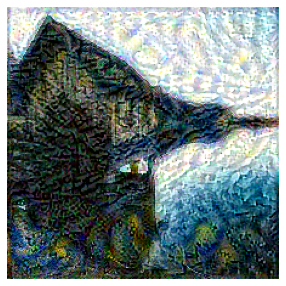

In [20]:
import PIL

tensor = image*255
tensor = np.array(tensor, dtype=np.uint8)

if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]

tensor =  PIL.Image.fromarray(tensor)

plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(np.array(tensor), cv2.COLOR_BGR2RGB))

plt.axis('off');